<a href="https://colab.research.google.com/github/fulllz/DSProjects/blob/main/Project%204%20Customer%20Lifetime%20Value%20and%20Customer%20Segmentation%20for%20Online%20Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4   
# Customer Lifetime Value and Customer Segmentation for Online Retail

**Part 1 : importing and Cleaning the dataset**

*     Importing the data
*     Checking missing values 
*     Checking negative values and outliers
   
    
**Part 2 : Exploratory Data Analysis**

*     TOP 10 customers with most number of orders 
*     TOP 10 customers with highest money spend
*     Orders and money spend with defferent time periods
*     Rank of orders and money spend for different country 
    
    
**Part 3 : Customer Lifetime Value**
 
*     Basic Frequency/Recency analysis using the BG/NBD model
*     Estimating customer lifetime value using the Gamma-Gamma model



**Part 4 : Customer Segmentation**
 
*     K-means Clustering

## importing and Cleaning the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
plt.style.use('bmh')
%matplotlib inline
import seaborn as sns
import missingno as msno
#import warnings
#warnings.filterwarnings('ignore')
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes import GammaGammaFitter
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We found some missing values in the columns of *CustomerID* and *Description*. 

**Checking missing values**

In [ ]:
df_missing =pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
df_missing.rename(columns={0:'missing_num'}, inplace=True)
df_missing['missing_perc']=(df_missing['missing_num']/len(df))*100
df_missing

,missing_num,missing_perc
CustomerID,135080,24.926694
Description,1454,0.268311
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceNo,0,0.000000


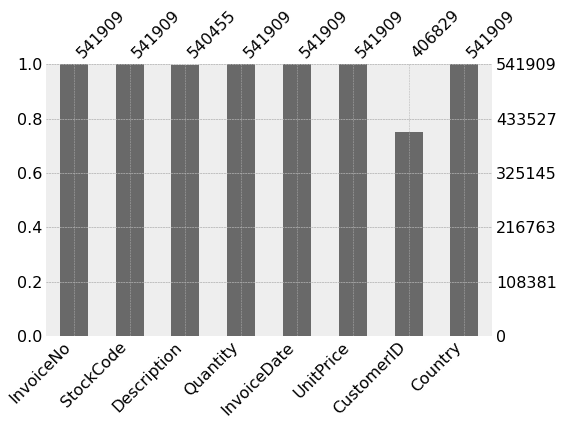

In [ ]:
msno.bar(df,figsize=(8, 5));

In [ ]:
#dropping miss values
df=df.dropna()
df.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

In [ ]:
df.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


**Quantity**

negative number: return products  
outliers: minima and maxima are very large

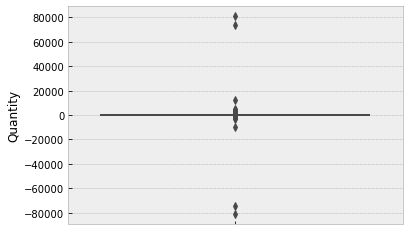

In [ ]:
ax = sns.boxplot(x=df['Quantity'],orient='v')

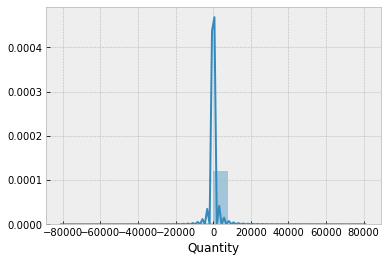

In [ ]:
ax = sns.distplot(df['Quantity'], bins=20)

We can see there are negative values in Quantity.This is possible when Items are given back.We need to Drop this negative Outliers from our Dataset

In [ ]:
df=df[df.Quantity>0]
df.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


## Exploratory Data Analysis

In [ ]:
# make a copy for EDA
df2=df.copy()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [ ]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#Calculating the sales by a customer
df2['Sales']=df2['Quantity']*df2['UnitPrice']
#Adding Month,Day and Hour Columns to our dataset
df2.insert(loc=5, column='year_month', value=df2['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df2.insert(loc=6, column='month', value=df2.InvoiceDate.dt.month)
# +1 to make Monday=1.....until Sunday=7
df2.insert(loc=7, column='day', value=(df2.InvoiceDate.dt.dayofweek)+1)
df2.insert(loc=8, column='hour', value=df2.InvoiceDate.dt.hour)
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,year_month,month,day,hour,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,201012,12,3,8,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,201012,12,3,8,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,201012,12,3,8,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,201012,12,3,8,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,201012,12,3,8,3.39,17850.0,United Kingdom,20.34


**Check TOP 10 most number of orders**

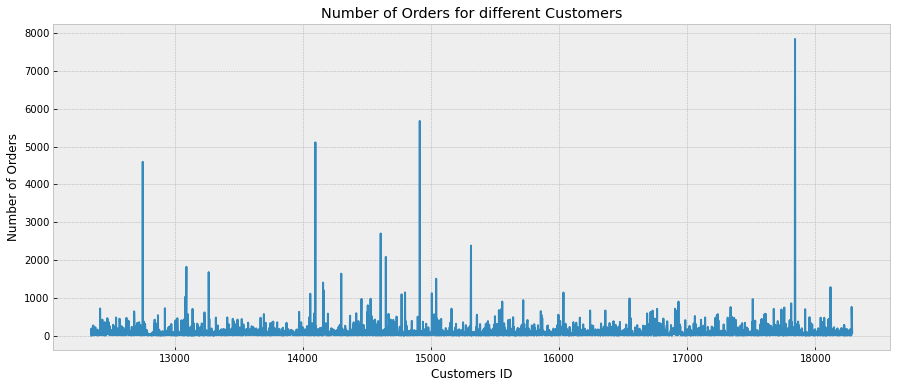

In [ ]:
orders = df2.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

They long bars indicate the customers that make the highest sale by Volume

In [ ]:
print('The TOP 10 customers with most number of orders...')
orders.sort_values(by='InvoiceNo', ascending=False).head(10)

The TOP 10 customers with most number of orders...


,CustomerID,Country,InvoiceNo
4019,17841.0,United Kingdom,7847
1888,14911.0,EIRE,5677
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4596
1670,14606.0,United Kingdom,2700
2185,15311.0,United Kingdom,2379
1698,14646.0,Netherlands,2080
570,13089.0,United Kingdom,1818
699,13263.0,United Kingdom,1677
1443,14298.0,United Kingdom,1637


**Check TOP 10 highest money spent**

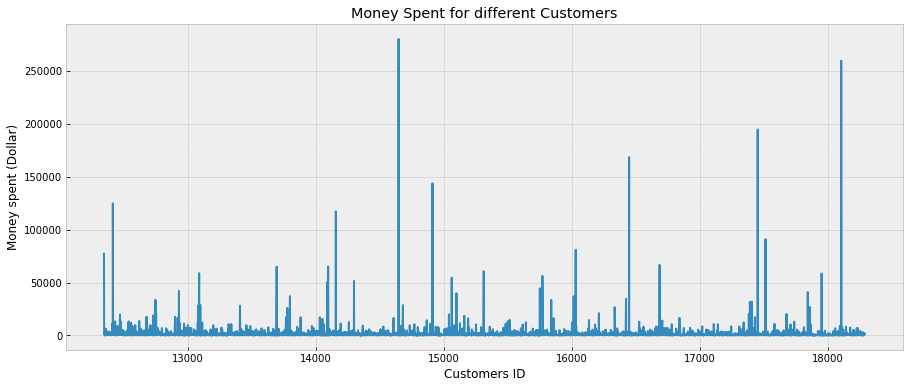

In [ ]:
money_spent = df2.groupby(by=['CustomerID','Country'], as_index=False)['Sales'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.CustomerID, money_spent.Sales)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

So now we have the info of he customers spending the highest amount.This customers are important for us.They drive the business revenue.

In [ ]:
print('The TOP 10 customers with highest money spent...')
money_spent.sort_values(by='Sales', ascending=False).head(10)

The TOP 10 customers with highest money spent...


,CustomerID,Country,Sales
1698,14646.0,Netherlands,280206.02
4210,18102.0,United Kingdom,259657.30
3737,17450.0,United Kingdom,194550.79
3017,16446.0,United Kingdom,168472.50
1888,14911.0,EIRE,143825.06
57,12415.0,Australia,124914.53
1342,14156.0,EIRE,117379.63
3780,17511.0,United Kingdom,91062.38
2711,16029.0,United Kingdom,81024.84
0,12346.0,United Kingdom,77183.60


**orders per month**

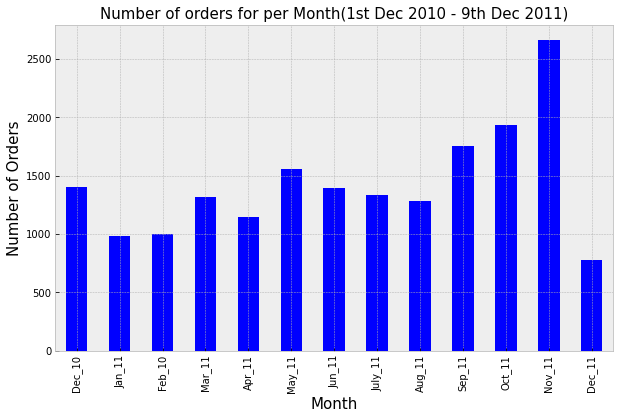

In [ ]:
ax=df2.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color='blue',figsize=(10,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for per Month(1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_10','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'));

**orders for each day in the week**

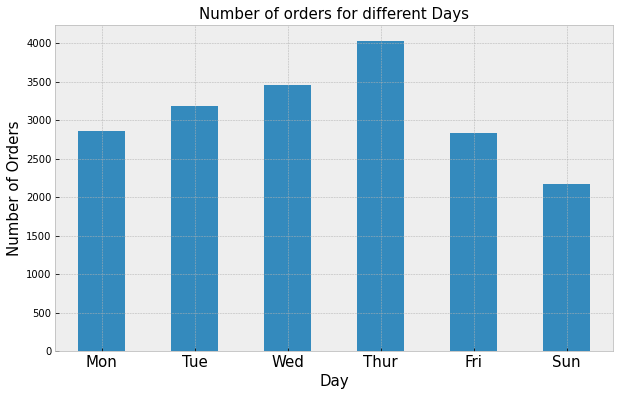

In [ ]:
group_day_orders = df2.groupby('InvoiceNo')['day'].unique().value_counts().sort_index()
ax = group_day_orders.plot(kind='bar',figsize=(10,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

**orders for each hour**

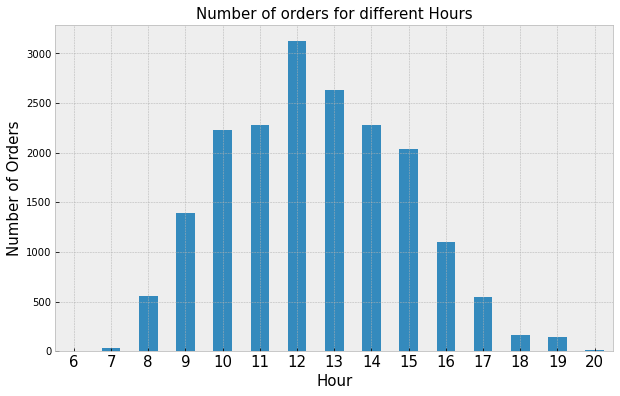

In [ ]:
group_hour_orders = df2.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index()
ax =group_hour_orders.plot(kind='bar', figsize=(10,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

**money spend for each hour**

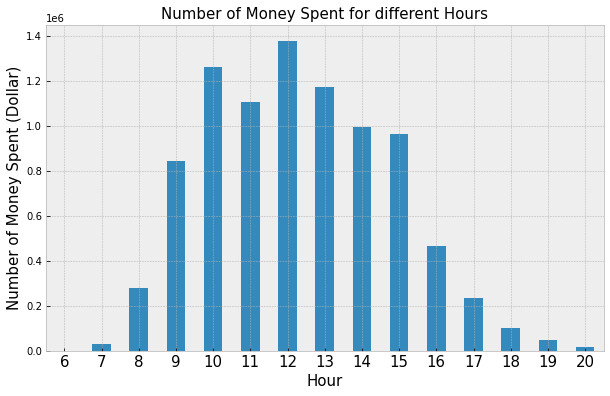

In [ ]:
group_hour_orders = df2.groupby('hour')['Sales'].sum().sort_index()
ax =group_hour_orders.plot(kind='bar', figsize=(10,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Money Spent (Dollar)',fontsize=15)
ax.set_title('Number of Money Spent for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

More sale happends in the Afternoon.We can allot resources accordingly to cater to everyday needs.

**orders for each country**

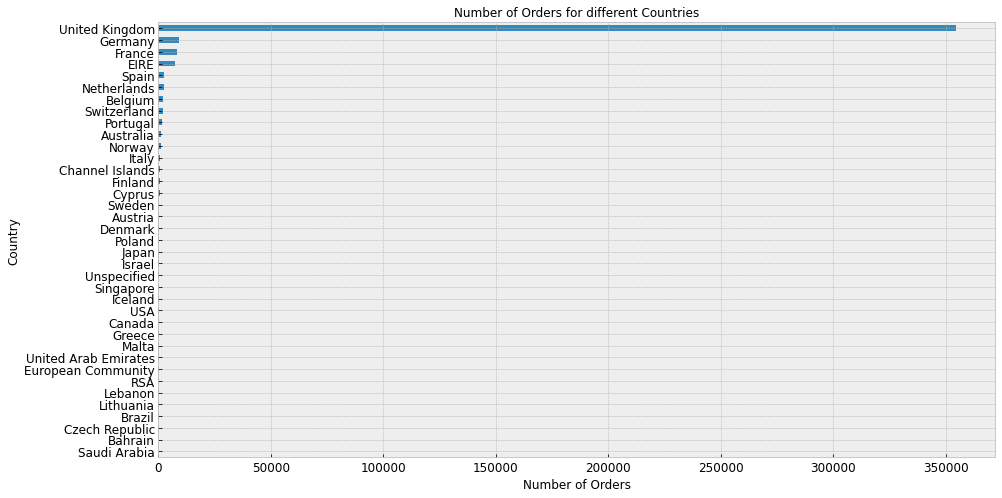

In [ ]:
group_country_orders = df2.groupby('Country')['InvoiceNo'].count().sort_values()
# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

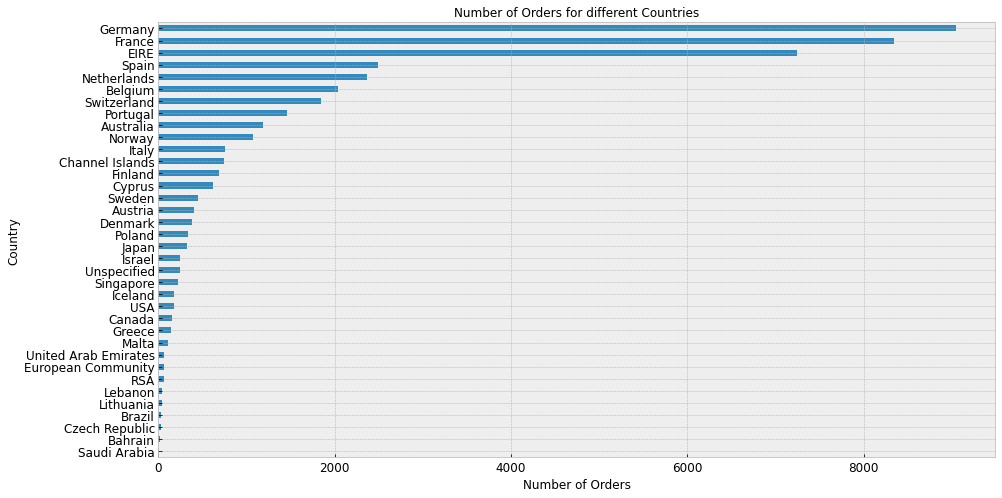

In [ ]:
group_country_orders = df2.groupby('Country')['InvoiceNo'].count().sort_values()
del group_country_orders['United Kingdom']
# plot number of unique customers in each country (without UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

We see that UK by far has the highest number of orders.To get better representation of other countries we need to drop the UK data and then make a plot.

**money spent by each country**

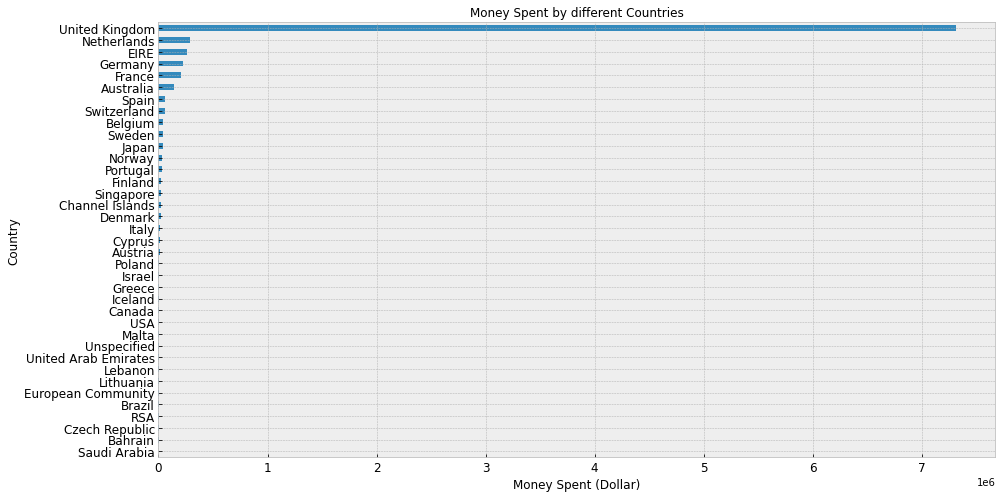

In [ ]:
group_country_sales= df2.groupby('Country')['Sales'].sum().sort_values()
# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_sales.plot(kind='barh', fontsize=12)
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

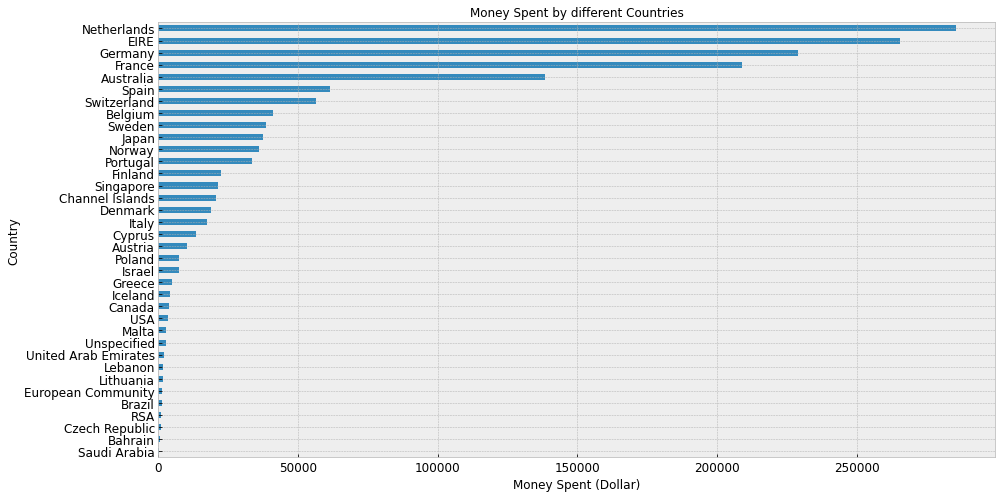

In [ ]:
group_country_sales = df2.groupby('Country')['Sales'].sum().sort_values()
# plot total money spent by each country without UK
del group_country_sales['United Kingdom']
plt.subplots(figsize=(15,8))
group_country_sales.plot(kind='barh', fontsize=12)
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

UK, Netherlands, Ireland and Germany, have high Sales in term of money spent.

 ## Customer Lifetime Value

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [ ]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols]

In [ ]:
df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [ ]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


* **frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
* **recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
* **T** represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* **monetary_value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

### Basic Frequency/Recency analysis using the BG/NBD model

In [ ]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


### Visualizing our Frequency/Recency Matrix

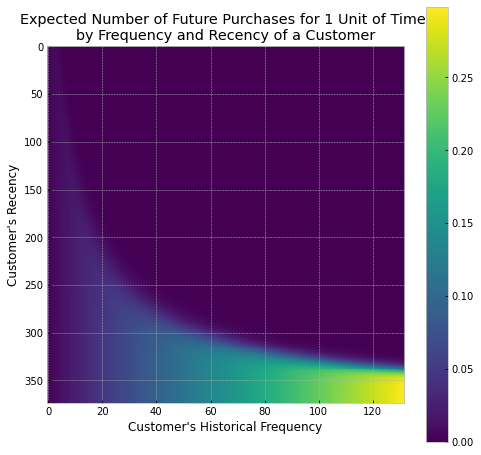

In [ ]:
plt.figure(figsize=(8,8))
plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 120 times from us, and their latest purchase was when they were 350 days old (given the individual is 350 days old), then they are our best customer (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future.

Customers who have purchased a lot but not recently (top-right corner), have probably dropped out.

There’s also that beautiful “tail” around (20,250). That represents the customer who buys infrequently, and we’ve not seen him or her very recently, so they might buy again - we’re not sure if they dropped out or just between purchases.

We can predict which customers are still alive:

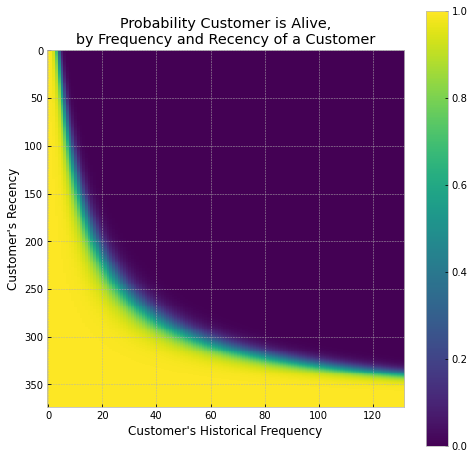

In [ ]:
plt.figure(figsize=(8,8))
plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely "alive". 

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

### Ranking customers from best to worst

Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911.0,131.0,372.0,373.0,1093.661679,0.298312
12748.0,113.0,373.0,373.0,298.360885,0.257581
17841.0,111.0,372.0,373.0,364.452162,0.253053
15311.0,89.0,373.0,373.0,677.729438,0.203269
14606.0,88.0,372.0,373.0,135.890114,0.201005


We can see that the customer who has made 131 purchases, and bought very recently from us, has a probability of 29.8% to buy again in the next period (tomorrow).

### Assessing model fit
we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare our data versus artificial data simulated with your fitted model’s parameters.

<Figure size 576x576 with 0 Axes>

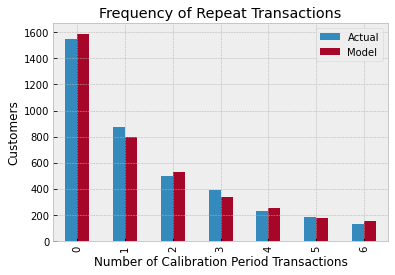

In [ ]:
plt.figure(figsize=(8,8))
plot_period_transactions(bgf)

### More model fitting
We can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


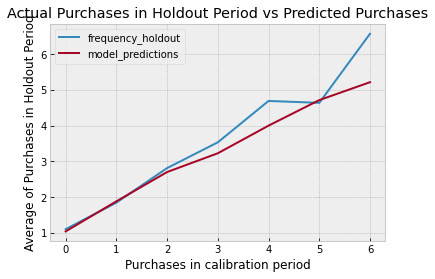

In [ ]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Customer Predictions
Based on customer history, we can predict what an individuals future purchases might look like:

In [ ]:
#predict purchases in 10 periods
t = 10 
individual = data.iloc[100]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.4637079400536178

In [ ]:
data.iloc[100]

frequency               19.000000
recency                362.000000
T                      364.000000
monetary_value         919.138947
predicted_purchases      0.045793
Name: 12471.0, dtype: float64

Customer ID 12471's predicted purchase is 0.045793 in 10 periods.

### Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

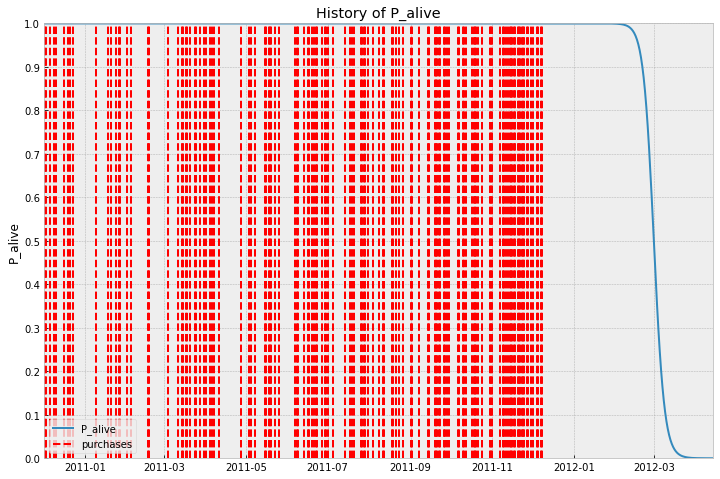

In [ ]:
id = 14911
days_since_birth = 500
sp_trans = df.loc[df['CustomerID'] == id]
plt.figure(figsize=(12,8))
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

### Estimating customer lifetime value using the Gamma-Gamma model
For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [ ]:
returning_customers_summary = data[data['frequency']>0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.015656
12348.0,3.0,283.0,358.0,301.480000,0.008956
12352.0,6.0,260.0,296.0,368.256667,0.018697
12356.0,2.0,303.0,325.0,269.905000,0.007172
12358.0,1.0,149.0,150.0,683.200000,0.008340


### The Gamma-Gamma model and the independence assumption
We are going to estimate the CLV for our userbase with the Gamma-Gamma submodel. 

In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


We can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


We can now estimate the average transaction value:

In [ ]:
ggf.conditional_expected_average_profit(data['frequency'],
                                        data['monetary_value']).head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64

In [ ]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.12840327472315, Average profit: 477.3586892535673


In [ ]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

CustomerID
12346.0     295.248495
12347.0    3010.933997
12348.0    1008.692677
12349.0    1337.106427
12350.0     306.932977
12352.0    2372.739690
12353.0     426.098903
12354.0     386.464312
12355.0     411.043379
12356.0     784.161526
Name: clv, dtype: float64


## Customer Segmentation

## K-means Clustering

 **Preprocessing data**
* symmetric distribution of variables (not skewed)
* k means assumes equal mean and equal variance

In [ ]:
rfm_cluster = data[['frequency', 'recency', 'monetary_value']]
rfm_cluster.head()

,frequency,recency,monetary_value
CustomerID,,,
12346.0,0.0,0.0,0.000000
12347.0,6.0,365.0,599.701667
12348.0,3.0,283.0,301.480000
12349.0,0.0,0.0,0.000000
12350.0,0.0,0.0,0.000000


In [ ]:
rfm_cluster = rfm_cluster[(rfm_cluster['frequency'] >0) & (rfm_cluster['recency'] > 0)]

In [ ]:
rfm_cluster.head()

,frequency,recency,monetary_value
CustomerID,,,
12347.0,6.0,365.0,599.701667
12348.0,3.0,283.0,301.480000
12352.0,6.0,260.0,368.256667
12356.0,2.0,303.0,269.905000
12358.0,1.0,149.0,683.200000


In [ ]:
rfm_cluster.describe()

,frequency,recency,monetary_value
count,2790.000000,2790.000000,2790.000000
mean,4.454122,203.328674,477.358689
std,6.930419,111.459556,3245.622467
min,1.000000,1.000000,1.000000
25%,1.000000,106.000000,187.165000
50%,3.000000,211.000000,309.473250
75%,5.000000,301.750000,458.370500
max,131.000000,373.000000,168469.600000


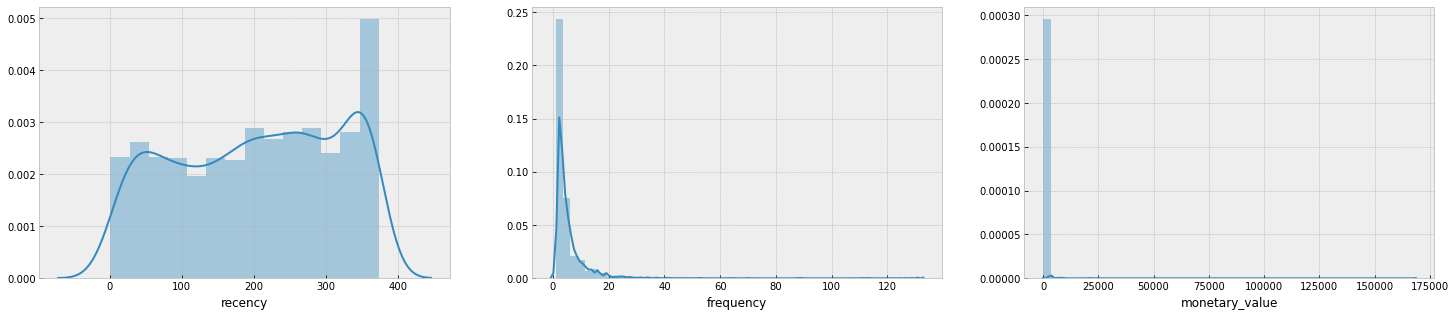

In [ ]:
f,ax = plt.subplots(figsize=(25, 5))
plt.subplot(1, 3, 2); sns.distplot(rfm_cluster['frequency'])
plt.subplot(1, 3, 1); sns.distplot(rfm_cluster['recency'])
plt.subplot(1, 3, 3); sns.distplot(rfm_cluster['monetary_value'])

As we can see from the plots above, the data is fairly skewed and it is generally good practice to have the mean and variance normalized before we can perform a clustering. If we didn't do so, we would have one feature dominating our model. To centralize our data we can perform a simple log transform.

In [ ]:
rfm_cluster1 = rfm_cluster.copy()

In [ ]:
rfm_cluster1['monetary_value'] = np.log(rfm_cluster['monetary_value'])

In [ ]:
rfm_cluster1.head()

,frequency,recency,monetary_value
CustomerID,,,
12347.0,6.0,365.0,6.396432
12348.0,3.0,283.0,5.708704
12352.0,6.0,260.0,5.908780
12356.0,2.0,303.0,5.598070
12358.0,1.0,149.0,6.526788


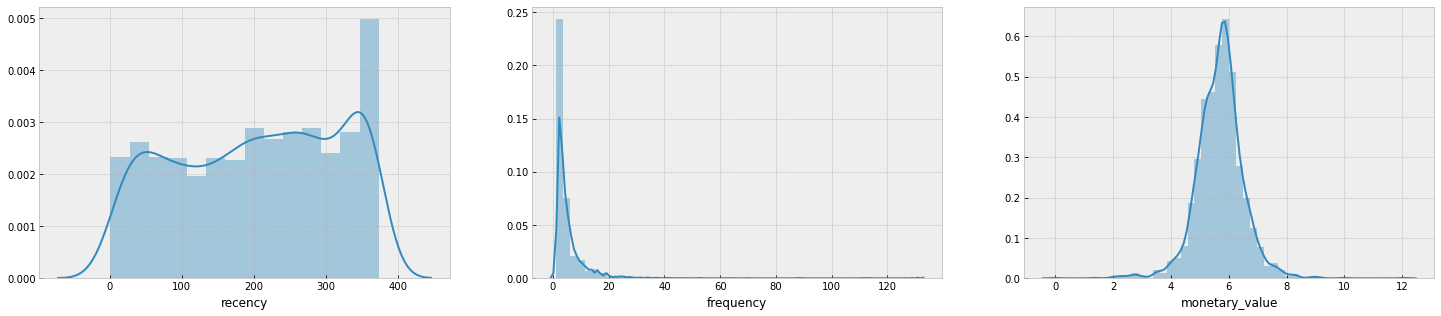

In [ ]:
f,ax = plt.subplots(figsize=(25, 5))
plt.subplot(1, 3, 1); sns.distplot(rfm_cluster1['recency'])
plt.subplot(1, 3, 2); sns.distplot(rfm_cluster1['frequency'])
plt.subplot(1, 3, 3); sns.distplot(rfm_cluster1['monetary_value'])

In [ ]:
scaler = StandardScaler()
scaler.fit(rfm_cluster1)
rfm_norm = scaler.fit_transform(rfm_cluster1)
rfm_norm
rfm_norm = pd.DataFrame(data=rfm_norm, index=rfm_cluster1.index, columns=rfm_cluster1.columns)
rfm_norm.describe()

,frequency,recency,monetary_value
count,2.790000e+03,2.790000e+03,2.790000e+03
mean,-1.104055e-16,3.113798e-17,5.667708e-16
std,1.000179e+00,1.000179e+00,1.000179e+00
min,-4.984895e-01,-1.815591e+00,-7.041901e+00
25%,-4.984895e-01,-8.733762e-01,-5.712827e-01
50%,-2.098549e-01,6.883843e-02,5.065085e-02
75%,7.877966e-02,8.831811e-01,5.364502e-01
max,1.826276e+01,1.522541e+00,7.841674e+00


**Choosing number of clusters**
* Visual methods - elbow criterion
    * plot the number of clusters against within-cluster sum of squared errors
    * identify an 'elbow' in the plot
    * elbow - a point representing an 'optimal' number of clusters
    * best to choose the point on elbow
    * use as a guide but test multiple solutions
    * analyze their properties - average RFM values
    * compare against each other and choose one which makes most business sense

In [ ]:
# Fit Kmeans and calculate SSE for each K
sse = {}
for k in range(1,21):
    #Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters = k, random_state=1)
    #Fit KMeans on the normalized dataset
    kmeans.fit(rfm_norm)
    #Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

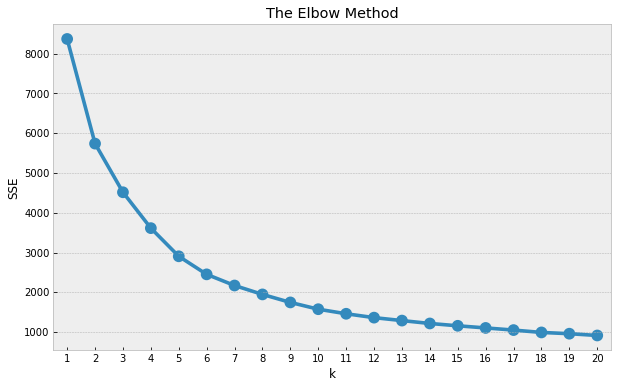

In [ ]:
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
# plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_norm)

KMeans(n_clusters=5)

In [ ]:
kmeans.cluster_centers_

array([[-3.46694647e-01, -7.75516510e-01,  6.25662494e-01],
       [ 8.37791467e-03,  7.88464112e-01,  9.71093177e-02],
       [ 1.31085697e+01,  1.50587596e+00,  3.59146822e-01],
       [-3.66873901e-01, -8.75663802e-01, -1.11390534e+00],
       [ 2.01991871e+00,  1.27963530e+00,  6.77536793e-01]])

In [ ]:
kmeans.labels_

array([1, 1, 1, ..., 3, 1, 0])

In [ ]:
rfm_cluster['Cluster'] = kmeans.labels_

In [ ]:
rfm_cluster.groupby(['Cluster']).agg({'recency': 'mean','frequency': 'mean',
                                         'monetary_value': ['mean', 'count'],}).round(0)

recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         117.0       2.0          824.0   773
1         291.0       5.0          379.0  1151
2         371.0      95.0          518.0     7
3         106.0       2.0          139.0   657
4         346.0      18.0          811.0   202

**Relative importance of segment attributes**
* useful technique to identify relative importance of each segment's attribute
* calculate average values of each cluster
* calculate average values of population
* calculate importance score by dividing them and subtracting 1 
* compare the averages of the profiling variables of each segment relative to the average of the variables across the whole population.

In [ ]:
rfm_cluster.groupby(['Cluster']).mean()

,frequency,recency,monetary_value
Cluster,,,
0,2.053040,116.525226,823.781262
1,4.509991,291.176368,378.858265
2,95.285714,371.142857,517.574267
3,1.910198,105.925419,139.256639
4,18.450495,345.930693,811.224417


In [ ]:
rfm_cluster1 = rfm_cluster[['frequency', 'recency', 'monetary_value']]
rfm_cluster1.head()

,frequency,recency,monetary_value
CustomerID,,,
12347.0,6.0,365.0,599.701667
12348.0,3.0,283.0,301.480000
12352.0,6.0,260.0,368.256667
12356.0,2.0,303.0,269.905000
12358.0,1.0,149.0,683.200000


In [ ]:
# calculate relative importance of each attribute
cluster_avg = rfm_cluster.groupby(['Cluster']).mean()
population_avg = rfm_cluster1.mean()
# calculate relative importance of cluster's attribute value compared to population
# why minus 1? i dont get it
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))

         frequency  recency  monetary_value
Cluster                                    
0            -0.54    -0.43            0.73
1             0.01     0.43           -0.21
2            20.39     0.83            0.08
3            -0.57    -0.48           -0.71
4             3.14     0.70            0.70


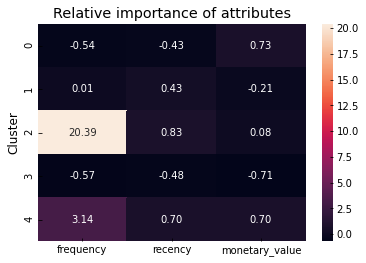

In [ ]:
plt.title('Relative importance of attributes')
sns.heatmap(data = relative_imp, annot = True, fmt='.2f')

**Silhouette analysis for KMeans clustering**

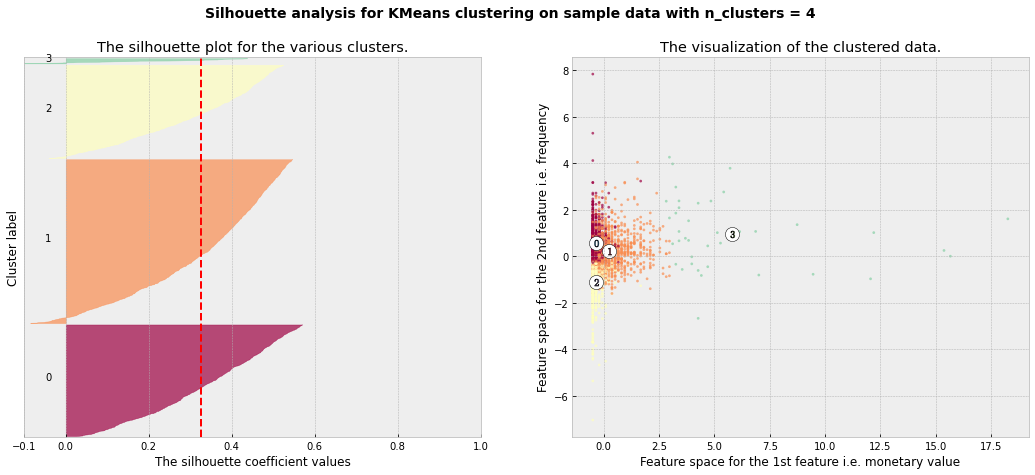

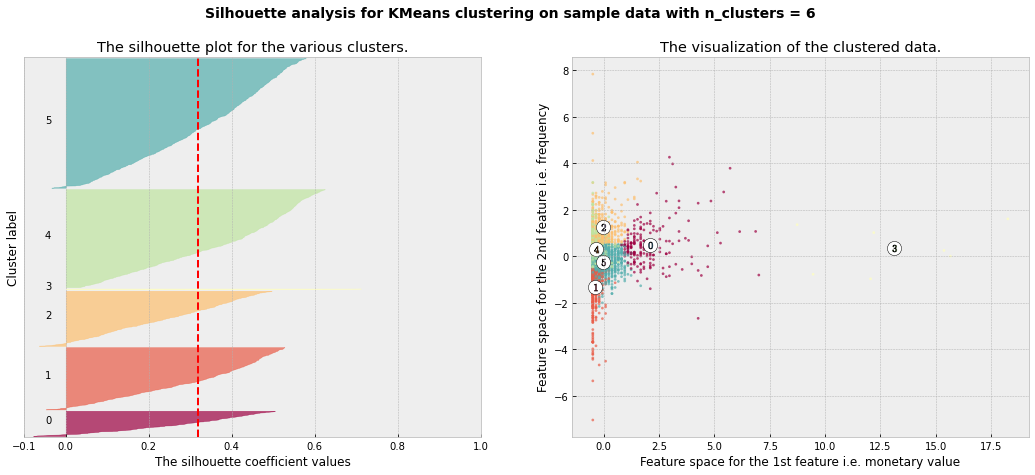

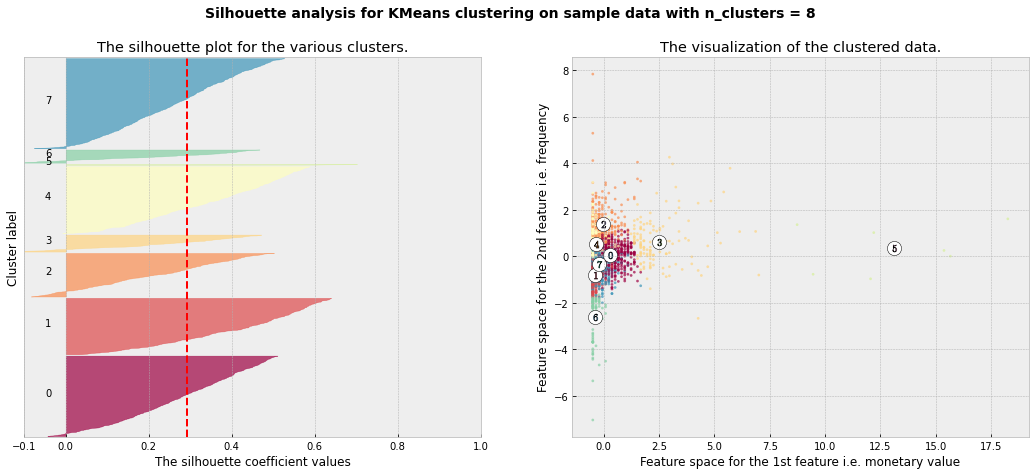

In [ ]:
X = rfm_norm

cluster_centers = dict()

for n_clusters in range(4,9,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X.iloc[:, feature1], X.iloc[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()

In [ ]:
features = ['frequency', 'recency', 'monetary_value']

In [ ]:
for i in range(4,9,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 4 number of clusters
      frequency        recency  monetary_value
0  7.912370e+00   2.411433e+52      471.627647
1  5.047379e+02  1.207770e+132      352.122683
2  7.005970e+00   3.537963e+50      121.047356
3  2.317819e+19  3.781345e+155      655.443599
Silhouette score for cluster 4 is 0.32514018833029884

for 6 number of clusters
      frequency        recency  monetary_value
0  1.632064e+08  6.421197e+150      444.005778
1  5.204755e+00   1.983887e+40      101.126702
2  7.272949e+01  3.622092e+115      811.200155
3  2.410238e+41  1.532127e+161      397.150028
4  7.093927e+00   7.677582e+41      381.448047
5  7.263311e+01  1.315948e+122      248.187392
Silhouette score for cluster 6 is 0.31876123369292375

for 8 number of clusters
      frequency        recency  monetary_value
0  5.389857e+02  4.448742e+141      311.967346
1  5.273865e+00   1.897357e+32      153.744551
2  5.679871e+01  1.839064e+110      905.077066
3  3.166742e+09  1.787770e+151      497.085449
4  6.450601e+00 

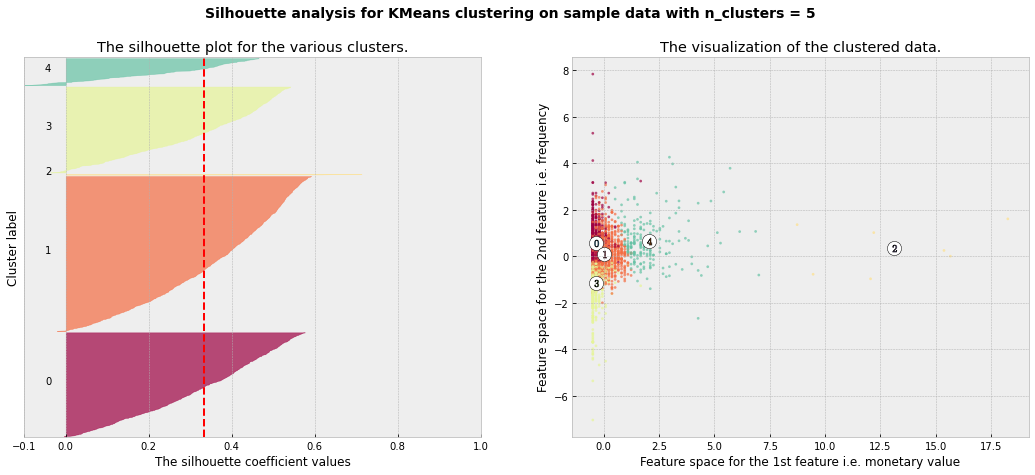

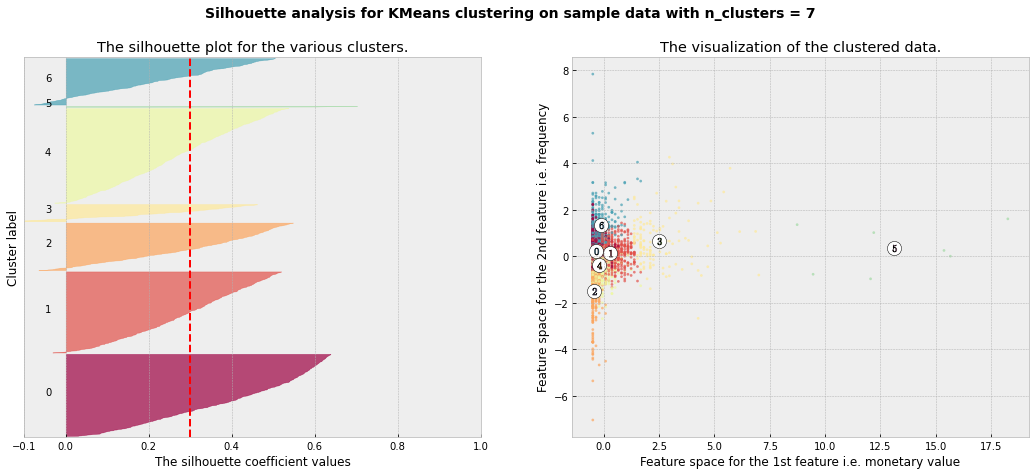

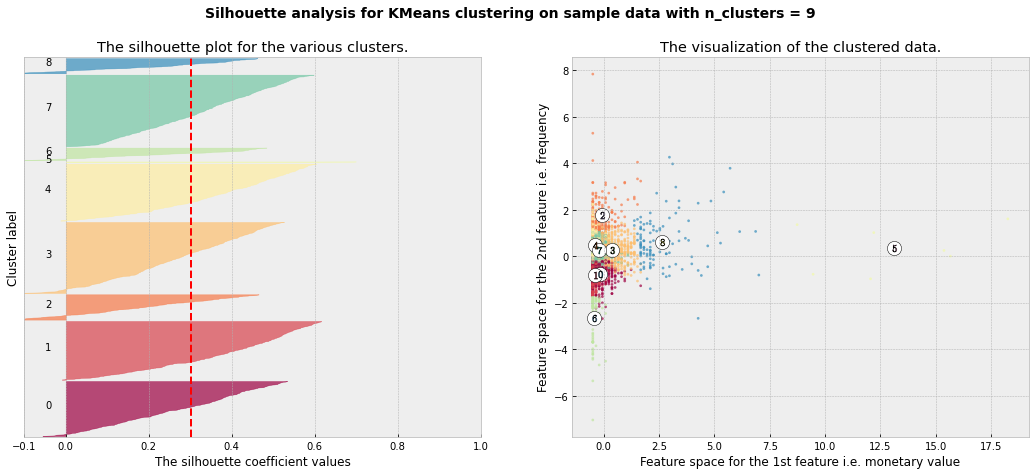

In [ ]:
X = rfm_norm

cluster_centers = dict()

for n_clusters in range(5,10,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X.iloc[:, feature1], X.iloc[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()

In [ ]:
for i in range(5,10,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 5 number of clusters
      frequency        recency  monetary_value
0  7.650332e+00   3.569514e+49      479.599227
1  8.974524e+01  2.455864e+126      326.322268
2  2.410238e+41  1.532127e+161      397.150028
3  6.892599e+00   4.090846e+46      118.677197
4  1.030263e+08  1.721041e+150      513.760289
Silhouette score for cluster 5 is 0.33201547234772605

for 7 number of clusters
      frequency        recency  monetary_value
0  6.364415e+00   1.375543e+34      363.069722
1  6.117927e+02  7.769890e+141      336.191194
2  4.544722e+00   1.520153e+34       88.792510
3  3.003599e+09  1.956563e+151      507.760393
4  1.909658e+01   7.708419e+98      216.546026
5  2.410238e+41  1.532127e+161      397.150028
6  3.213398e+01  2.045624e+100      896.428388
Silhouette score for cluster 7 is 0.2984425811202317

for 9 number of clusters
      frequency        recency  monetary_value
0  2.973559e+01  1.969227e+116      161.962336
1  5.633323e+00   2.656187e+36      153.072415
2  4.999470e+01  

We finished the Silhouette analysis for KMeans clustering with n_clusters=4, 5, 6, 7, 8, 9. The Highest Silhouette-score is 0.33 for n_clusters=5. It confirms 5 clusters is the best customer segmentation in our dataset.